In [30]:
# 데이터 불러오기 및 전처리
# 심장 질환 데이터
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

heart = pd.read_csv('./data/heart.csv')

#범주형/연속형 변수 분리
cat_col = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
con_col = ['age', 'trtbps', 'thalachh', 'oldpeak']

heart_raw = heart.copy() #원본 데이터 copy

#get_dummies()로 범주형 변수 원핫인코딩
heart = pd.get_dummies(heart, columns=cat_col, drop_first=True)

#train, test, val 분리
X = heart.drop(['output'], axis=1)
y = heart[['output']]

In [ ]:
# 1. 데이터 train,test (8:2) 비율로 나눈 후 train 데이터는 다시 train,val (9;1)로 나누시오.(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [37]:
# 2. LGBMClassifier 객체를 생성하고 학습/예측하여 정확도를 측정하시오. (***부분 )
import lightgbm as lgb
from sklearn.metrics import accuracy_score

lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary')
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_val)
accuracy_score(y_val, y_pred)

0.7377049180327869

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

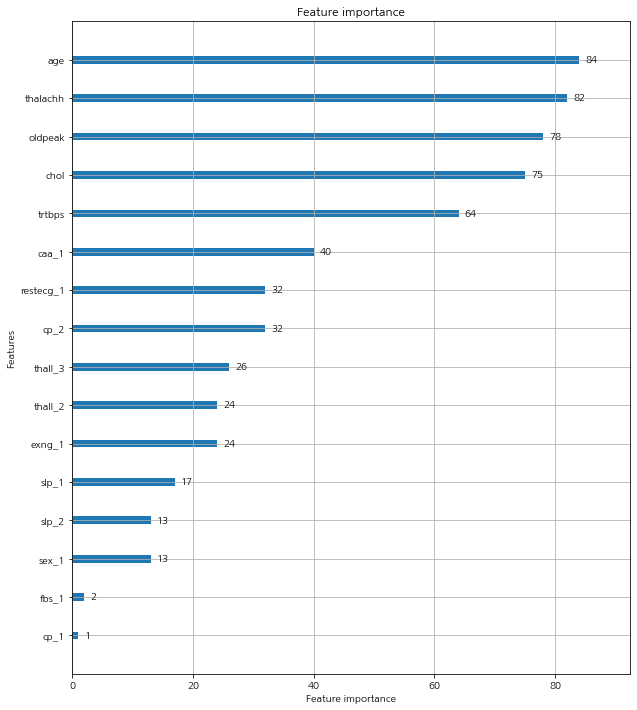

In [39]:
#### 3. plot_importance 라이브러리를 활용해 피처 중요도 그래프를 그리시오.
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgb_clf, ax=ax)

#### 구남이

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

citrus_df = pd.read_csv('./data/citrus.csv')
y_citrus_df = (citrus_df.name == 'orange').astype(int)
X_citrus_df = citrus_df.drop('name', axis=1)

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_citrus_df, y_citrus_df, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [45]:
from hyperopt import hp

# 검색 공간 설정
# max_depth는 5에서 0까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01애소 0.2사이 정규 분포된 값으로 검색

# Q1. 'max_depth', 'min_child_weight'는 정수형 파라미터입니다. ***에 들어가야하는 함수는 무엇인가요?

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

# 목적 함수 설정

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    # Q2. 목적함수의 반환값을 정확도로 설정할 수 있도록 빈칸을 채워주세요.    
    return {'loss': -1*np.mean(accuracy) , 'status': STATUS_OK}

In [46]:
# fmin()함수를 사용해 최적의 하이퍼 파라미터 도출

from hyperopt import fmin, tpe, Trials

# Q3. 앞에서 설정한 목적함수, 하이퍼 파라미터 검색 공간을 인자로 입력해주세요.

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

# 최적 하이퍼 파라미터들을 이용해서 XGBClassifier를 재학습한 후 성능 평가 결과를 확인

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  2%|▉                                               | 1/50 [00:03<02:34,  3.16s/trial, best loss: -0.9502505922693647]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  4%|█▉                                              | 2/50 [00:04<02:05,  2.62s/trial, best loss: -0.9532501704353722]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  6%|██▉                                             | 3/50 [00:06<01:52,  2.40s/trial, best loss: -0.9653756708768494]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  8%|███▊                                            | 4/50 [00:08<01:49,  2.38s/trial, best loss: -0.9653756708768494]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 10%|████▊                                           | 5/50 [00:11<01:57,  2.60s/trial, best loss: -0.9653756708768494]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 12%|█████▊                                          | 6/50 [00:13<01:45,  2.40s/trial, best loss: -0.9653756708768494]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 14%|██████▋                                         | 7/50 [00:16<01:44,  2.44s/trial, best loss: -0.9653756708768494]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 16%|███████▋                                        | 8/50 [00:18<01:44,  2.48s/trial, best loss: -0.9658755146229376]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 18%|████████▋                                       | 9/50 [00:20<01:34,  2.30s/trial, best loss: -0.9658755146229376]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 20%|█████████▍                                     | 10/50 [00:23<01:31,  2.30s/trial, best loss: -0.9658755146229376]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 22%|██████████▎                                    | 11/50 [00:27<01:55,  2.97s/trial, best loss: -0.9658755146229376]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 24%|███████████▎                                   | 12/50 [00:30<01:56,  3.07s/trial, best loss: -0.9658755146229376]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 26%|████████████▏                                  | 13/50 [00:33<01:47,  2.91s/trial, best loss: -0.9658755146229376]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 28%|█████████████▏                                 | 14/50 [00:37<02:00,  3.34s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 30%|██████████████                                 | 15/50 [00:40<01:52,  3.22s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 32%|███████████████                                | 16/50 [00:42<01:34,  2.77s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 34%|███████████████▉                               | 17/50 [00:44<01:26,  2.63s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 36%|████████████████▉                              | 18/50 [00:47<01:27,  2.73s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 38%|█████████████████▊                             | 19/50 [00:49<01:17,  2.49s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 40%|██████████████████▊                            | 20/50 [00:52<01:13,  2.45s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 42%|███████████████████▋                           | 21/50 [00:55<01:22,  2.85s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 44%|████████████████████▋                          | 22/50 [00:59<01:27,  3.12s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 46%|█████████████████████▌                         | 23/50 [01:03<01:27,  3.23s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 48%|██████████████████████▌                        | 24/50 [01:06<01:22,  3.18s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 50%|███████████████████████▌                       | 25/50 [01:09<01:20,  3.23s/trial, best loss: -0.9667504052616079]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 52%|████████████████████████▍                      | 26/50 [01:13<01:21,  3.39s/trial, best loss: -0.9678755459393532]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 54%|█████████████████████████▍                     | 27/50 [01:16<01:18,  3.39s/trial, best loss: -0.9678755459393532]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 56%|██████████████████████████▎                    | 28/50 [01:20<01:14,  3.40s/trial, best loss: -0.9692505147284196]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 58%|███████████████████████████▎                   | 29/50 [01:23<01:11,  3.38s/trial, best loss: -0.9692505147284196]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 60%|████████████████████████████▏                  | 30/50 [01:26<01:06,  3.33s/trial, best loss: -0.9692505147284196]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 62%|█████████████████████████████▏                 | 31/50 [01:29<01:02,  3.27s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 64%|██████████████████████████████                 | 32/50 [01:32<00:57,  3.20s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 66%|███████████████████████████████                | 33/50 [01:36<00:54,  3.22s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 68%|███████████████████████████████▉               | 34/50 [01:40<00:57,  3.60s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 70%|████████████████████████████████▉              | 35/50 [01:43<00:51,  3.43s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 72%|█████████████████████████████████▊             | 36/50 [01:47<00:50,  3.58s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 74%|██████████████████████████████████▊            | 37/50 [01:51<00:46,  3.61s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 76%|███████████████████████████████████▋           | 38/50 [01:54<00:42,  3.56s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 78%|████████████████████████████████████▋          | 39/50 [01:58<00:39,  3.60s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 80%|█████████████████████████████████████▌         | 40/50 [02:01<00:33,  3.40s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 82%|██████████████████████████████████████▌        | 41/50 [02:04<00:31,  3.51s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 84%|███████████████████████████████████████▍       | 42/50 [02:07<00:26,  3.34s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 86%|████████████████████████████████████████▍      | 43/50 [02:11<00:23,  3.36s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 88%|█████████████████████████████████████████▎     | 44/50 [02:15<00:22,  3.73s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 90%|██████████████████████████████████████████▎    | 45/50 [02:19<00:18,  3.61s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 92%|███████████████████████████████████████████▏   | 46/50 [02:22<00:13,  3.40s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 94%|████████████████████████████████████████████▏  | 47/50 [02:25<00:10,  3.37s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 96%|█████████████████████████████████████████████  | 48/50 [02:29<00:06,  3.43s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 98%|██████████████████████████████████████████████ | 49/50 [02:33<00:03,  3.65s/trial, best loss: -0.9697505928788158]

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|███████████████████████████████████████████████| 50/50 [02:38<00:00,  3.16s/trial, best loss: -0.9697505928788158]
best: {'colsample_bytree': 0.8605773347266229, 'learning_rate': 0.19696577128383452, 'max_depth': 12.0, 'min_child_weight': 1.0}


In [47]:
# Q4. fmin()으로 추출된 최적 하이퍼 파라미터를 직접 XGBClassifier에 인자로 입력하기 전에 
# 정수형 하이퍼 파라미터(max_depth와 min_child_weight)는 정수형으로 형 변환하고
# 실수형 하이퍼 파라미터(colsample_bytree, learning_rate)는 소수점 5자리까지만 변환 하세요.    
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'],5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'],5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.54028	validation_1-logloss:0.54652
[1]	validation_0-logloss:0.44035	validation_1-logloss:0.45175
[2]	validation_0-logloss:0.35976	validation_1-logloss:0.37458
[3]	validation_0-logloss:0.29785	validation_1-logloss:0.31612
[4]	validation_0-logloss:0.25025	validation_1-logloss:0.27113
[5]	validation_0-logloss:0.21674	validation_1-logloss:0.24335
[6]	validation_0-logloss:0.18577	validation_1-logloss:0.21467
[7]	validation_0-logloss:0.16078	validation_1-logloss:0.19270
[8]	validation_0-logloss:0.14036	validation_1-logloss:0.17541
[9]	validation_0-logloss:0.12644	validation_1-logloss:0.16455
[10]	validation_0-logloss:0.11425	validation_1-logloss:0.15455
[11]	validation_0-logloss:0.10196	validation_1-logloss:0.14372
[12]	validation_0-logloss:0.09376	validation_1-logloss:0.13892
[13]	validation_0-logloss:0.08534	validation_1-logloss:0.13250
[14]	validation_0-logloss:0.07738	validation_1-logloss:0.12654
[15]	validation_0-logloss:0.07034	validation_1-logloss:0.12092
[1

[130]	validation_0-logloss:0.00649	validation_1-logloss:0.07542
[131]	validation_0-logloss:0.00646	validation_1-logloss:0.07529
[132]	validation_0-logloss:0.00642	validation_1-logloss:0.07554
[133]	validation_0-logloss:0.00637	validation_1-logloss:0.07546
[134]	validation_0-logloss:0.00633	validation_1-logloss:0.07552
[135]	validation_0-logloss:0.00628	validation_1-logloss:0.07522
[136]	validation_0-logloss:0.00624	validation_1-logloss:0.07496
[137]	validation_0-logloss:0.00619	validation_1-logloss:0.07506
[138]	validation_0-logloss:0.00616	validation_1-logloss:0.07516
[139]	validation_0-logloss:0.00613	validation_1-logloss:0.07511
[140]	validation_0-logloss:0.00610	validation_1-logloss:0.07542
[141]	validation_0-logloss:0.00605	validation_1-logloss:0.07527
[142]	validation_0-logloss:0.00601	validation_1-logloss:0.07517
[143]	validation_0-logloss:0.00597	validation_1-logloss:0.07495
[144]	validation_0-logloss:0.00592	validation_1-logloss:0.07470
[145]	validation_0-logloss:0.00583	valid

[258]	validation_0-logloss:0.00340	validation_1-logloss:0.06927
[259]	validation_0-logloss:0.00339	validation_1-logloss:0.06933
[260]	validation_0-logloss:0.00337	validation_1-logloss:0.06929
[261]	validation_0-logloss:0.00336	validation_1-logloss:0.06909
[262]	validation_0-logloss:0.00335	validation_1-logloss:0.06906
[263]	validation_0-logloss:0.00334	validation_1-logloss:0.06893
[264]	validation_0-logloss:0.00333	validation_1-logloss:0.06908
[265]	validation_0-logloss:0.00331	validation_1-logloss:0.06893
[266]	validation_0-logloss:0.00331	validation_1-logloss:0.06884
[267]	validation_0-logloss:0.00330	validation_1-logloss:0.06898
[268]	validation_0-logloss:0.00329	validation_1-logloss:0.06905
[269]	validation_0-logloss:0.00328	validation_1-logloss:0.06919
[270]	validation_0-logloss:0.00326	validation_1-logloss:0.06914
[271]	validation_0-logloss:0.00326	validation_1-logloss:0.06916
[272]	validation_0-logloss:0.00324	validation_1-logloss:0.06895
[273]	validation_0-logloss:0.00323	valid

[386]	validation_0-logloss:0.00240	validation_1-logloss:0.06627
[387]	validation_0-logloss:0.00239	validation_1-logloss:0.06625
[388]	validation_0-logloss:0.00239	validation_1-logloss:0.06627
[389]	validation_0-logloss:0.00239	validation_1-logloss:0.06634
[390]	validation_0-logloss:0.00238	validation_1-logloss:0.06637
[391]	validation_0-logloss:0.00238	validation_1-logloss:0.06647
[392]	validation_0-logloss:0.00237	validation_1-logloss:0.06643
[393]	validation_0-logloss:0.00237	validation_1-logloss:0.06646
[394]	validation_0-logloss:0.00236	validation_1-logloss:0.06644
[395]	validation_0-logloss:0.00236	validation_1-logloss:0.06654
[396]	validation_0-logloss:0.00236	validation_1-logloss:0.06640
[397]	validation_0-logloss:0.00235	validation_1-logloss:0.06645
[398]	validation_0-logloss:0.00235	validation_1-logloss:0.06651
[399]	validation_0-logloss:0.00234	validation_1-logloss:0.06653
오차 행렬
[[985  10]
 [ 30 975]]
정확도: 0.9800, 정밀도: 0.9898, 재현율: 0.9701,    F1: 0.9799, AUC:0.9981


#### 강수민

In [59]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # 메타 모델

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

iris = load_iris()

X_data = iris.data
y_label = iris.target

In [60]:
# Q1. 테스트용 데이터를 20%로 설정해 학습용, 테스트용 데이터를 분할하시오
X_train , X_test , y_train , y_test = train_test_split(X_data,y_label, test_size=0.2)

## 스텝 1 구현

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  

        model.fit(X_tr , y_tr)       
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred , test_pred_mean

In [62]:
# 개별 모델 객체 생성
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression()

# Q2. 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기(n_split=5 로 설정하세요)
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 5)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test,5)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,5)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test,5)


KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [64]:
# 스텝 2 구현

# Q3. 각 모델별 학습 데이터와 테스트 데이터 합치기(칼럼 레벨로 합쳐주기)
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

# Q4. 최종 모델에 학습 시키고, 예측 정확도 확인하기

lr_final.fit(X_train,y_train)
stack_final = lr_final.predict(X_test)

print(accuracy_score(stack_final,y_test))


원본 학습 피처 데이터 Shape: (120, 4) 원본 테스트 피처 Shape: (30, 4)
스태킹 학습 피처 데이터 Shape: (120, 4) 스태킹 테스트 피처 데이터 Shape: (30, 4)
1.0


#### 박민영

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

water = pd.read_csv('./data/water_potability.csv')
water.head(3)

# 1. 데이터 정보를 확인하고, 결측치를 평균값으로 대체하세요.
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [55]:
water.fillna(water.mean(), inplace=True)
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [57]:
# 2. 이상치 제거를 위해 정의한 함수입니다. 빈칸을 채워주세요.
# Solids 변수에 대해서만 이상치 제거를 할 것입니다.

def get_outlier(df = None, column = None, weight = 1.5):
    solid = df[column]
    quantile_25 = np.percentile(solid, 25)
    quantile_75 = np.percentile(solid, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함
    Iqr = quantile_75 - quantile_25
    Iqr_weight = Iqr * weight
    lowest_val = quantile_25 - Iqr_weight
    highest_val = quantile_75 + Iqr_weight
    # 최대값보다 크거나 최소값보다 작은 값을 outlier로 설정하고 DataFrame index 반환
    outlier_index = solid[(solid < lowest_val) | (solid > highest_val)].index
    return outlier_index

# 이상치 인덱스 확인
outlier_index = get_outlier(df = water, column = 'Solids', weight = 1.5)
print('이상치 데이터 인덱스 :', outlier_index)

이상치 데이터 인덱스 : Int64Index([ 142,  186,  283,  287,  366,  378,  405,  516,  546,  613,  666,
             987, 1031, 1068, 1077, 1096, 1186, 1302, 1332, 1343, 1445, 1462,
            1527, 1554, 1556, 1746, 1784, 1815, 1858, 1955, 1984, 2012, 2497,
            2602, 2680, 2758, 2891, 2993, 3014, 3062, 3130, 3150, 3162, 3190,
            3226, 3236, 3271],
           dtype='int64')


In [58]:
# 3. water 데이터프레임에서 이상치를 제거해주세요.
water.drop(outlier_index, axis=0, inplace=True)

In [ ]:
# 4. 아래는 HyperOpt를 통해 최적의 하이퍼 파라미터를 찾으세요.
# 빈칸을 알맞게 채워주세요.

# 데이터 분리
X_features = water.iloc[:, :-1]
y_label = water.iloc[:, -1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size = 0.1, random_state = 156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size = 0.1, random_state = 156)

# HyperOpt를 통한 최적 하이퍼 파라미터 추출 - (1) 입력값 설정
from hyperopt import hp

# max_depth는 5에서 20까지 1 간격으로, min_child_weight는 1에서 2까지 1 간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2사이 정규분포된 값으로 검색
xgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1)}

# HyperOpt를 통한 최적 하이퍼 파라미터 추출 - (2) 목적함수 설정

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임 -> -1을 정확도에 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            learning_rate = search_space['learning_rate'],
                            colsample_bytree = search_space['colsample_bytree'],
                            eval_metric = 'logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv = 3)
    
    # accuracy는 cv = 3 개수만큼의 정확도 결과를 가지므로 이를 평균해서 반환하되 -1을 곱해줌
    return {'loss' : -1 * np.mean(accuracy), 'status' : STATUS_OK}

# # HyperOpt를 통한 최적 하이퍼 파라미터 추출 - (3) 최적 하이퍼 파라미터 값 추출

from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn = <빈칸>, 
            space = <빈칸>,
            algo = tpe.suggest,
            max_evals = 50, # 최대 반복 횟수를 지정
            trials = trial_val, rstate = np.random.default_rng(seed = 9))
print('best :', best)

print('colsample_bytree : {0}, learning_rate : {1}, max_depth : {2}, min_child_weight : {3}'.format(
                        round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
                        int(best['max_depth']), int(best['min_child_weight'])))